In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from a2c import A2C_Discrete
import torch

plt.style.use("bmh")

In [2]:
env = gym.make("LunarLander-v2")
n_episode = 1000
log_every_n = n_episode / 100
x = np.arange(0, n_episode, log_every_n)


def train(learning_rate, hidden_size):

    obversation_space = env.observation_space.shape[0]

    action_space = env.action_space
    action_space_type = type(env.action_space).__name__

    policy = A2C_Discrete(obversation_space, action_space, hidden_size, learning_rate)

    log_numsteps = []
    log_rewards = []

    for t in tqdm(range(n_episode)):
        current_state = env.reset()
        next_state = None
        states, actions, next_states, rewards, flags, logprobs = [], [], [], [], [], []
        done = False
        step = 0

        while not done:
            action, log_prob = policy.get_action(current_state)


            next_state, reward, done, _ = env.step(action)

            reward = -1 if done else reward

            states.append(current_state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            flags.append(int(done))
            logprobs.append(log_prob)

            step += 1

            current_state = next_state

        policy.learn({
            "states": torch.from_numpy(np.array(states)).to(torch.device("cuda")),
            "actions": torch.from_numpy(np.array(actions)).to(torch.device("cuda")),
            "next_states": torch.from_numpy(np.array(next_states)).to(torch.device("cuda")),
            "rewards": torch.from_numpy(np.array(rewards)).to(torch.device("cuda")),
            "flags": torch.from_numpy(np.array(flags)).to(torch.device("cuda")),
            "logprobs": torch.stack(logprobs).squeeze()
        })

        if not t % log_every_n:
            log_numsteps.append(step)
            log_rewards.append(np.sum(rewards))

    # agent.save("model.pt")

    return log_rewards, log_numsteps


/home/valentin/conda/envs/gym/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
log_rewards, log_numsteps = train(learning_rate=3e-4, hidden_size=128)


100%|██████████| 1000/1000 [02:24<00:00,  6.93it/s]


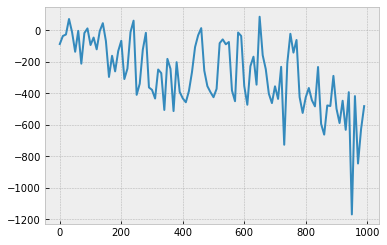

In [4]:
plt.plot(x, log_rewards)
plt.show()